In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from gPhoton.galextools import mag2counts
plt.rcParams.update({'font.size': 18})

In [2]:
# Import the function definitions that accompany this notebook tutorial.
nb_funcdef_file = "function_defs.py"
if os.path.isfile(nb_funcdef_file):
    from function_defs import get_inff, calculate_flare_energy, refine_flare_ranges
else:
    raise IOError("Could not find function definition file '" + nb_funcdef_file + "' that goes with this notebook.")

In [3]:
# Import the function definitions that accompany this notebook tutorial.
nb_recoverydef_file = "recovery_defs.py"
if os.path.isfile(nb_recoverydef_file):
    from recovery_defs import fake_a_flare, calculate_ideal_flare_energy, inject_and_recover
else:
    raise IOError("Could not find recovery definition file '" + nb_recoverydef_file + "' that goes with this notebook.")

In [4]:
# Restore the distance parameter.  Note: this assumes you've run the "generate_products" notebook already.  If not you
# will need to specify the distance to use.
%store -r distance
# If you have not run the "generate_products" notebook during this session, uncomment the line below and specify
# the distance to the system in parsecs.
distance = 1/(372.1631/1000) # parsecs

no stored variable or alias distance


In [5]:
# Define some parameters for our recovery tests.
band = 'NUV'
binsize = 30.
quiescent_mag = 18. # approx. NUV mag of UV Ceti
trange = [0., 1600.] # nominal GALEX visit start and end, in seconds
resolution = 0.05 # photon time resolution in seconds
detection_threshold = 3. # min. detection threshold allowed for a flare to be considered "detected", measured in sigma
max_flares_pervisit = 3 # max. number of flares to occur within a given Visit

Let's generate some synthetic flares and compare the energies measured by our flare finding algorithm with the known
values.  This is to demonstrate what a few of the synthetic flares look like and what the fits to them look like. The full simulation is done later.

In [6]:
def within_factor(x, y, fact):
    # Returns True if x and y are within a factor of 'fact' from each other.
    if x >= y:
        return x / y <= fact
    else:
        return y / x <= fact

In [7]:
# Now we'll do a big run (we won't make any plots though.)
# On a Macbook Pro this takes about 1.5 hours to run to completion for 100,000 flare lightcurves.
start_time = time.time()
random_seed = 42 # So that the exact results here when selecting random flare properties are repeatable.
rng = np.random.default_rng(seed=random_seed)
# How many flares to simulate here as an overview.
n_flares_to_make = 100000
# For each light curve, keep track of the number of flares detected, missed, and false positives.
all_n_det = np.asarray([0] * n_flares_to_make)
all_n_det_wrongenergy = np.asarray([0] * n_flares_to_make)
all_n_miss = np.asarray([0] * n_flares_to_make)
all_n_fp = np.asarray([0] * n_flares_to_make)
all_n_in_visit = np.asarray([0] * n_flares_to_make)
# Keep a list of all injected flare energies and all detected flare engeries to make histograms later.
# We store them as log10() energies.
all_injected_flare_energies_n1 = []
all_injected_flare_energies_n2 = []
all_injected_flare_energies_n3 = []
all_detected_flare_energies_n1 = []
all_detected_flare_energies_n2 = []
all_detected_flare_energies_n3 = []
# If a detected flare is within "energy_match_factor" count it as detected, otherwise detected_wrongenergy.
energy_match_factor = 5.

for i in range(n_flares_to_make):
    # Generate flares with random properties within plausible ranges.
    # Randomly determine how many flares to inject into the Visit, between 1 and 'max_flares_pervisit'.
    n_in_visit = rng.choice(np.asarray(range(max_flares_pervisit))+1)
    all_n_in_visit[i] = n_in_visit
    # First: select a peak NUV magnitude from within a specified range.
    fpeak_mags = rng.uniform(low=13, high=18, size=n_in_visit)
    # Have the flare start at some random time during the visit (avoid edges since we don't count truncated flares in
    # the paper analysis either.
    tpeaks = rng.uniform(low=trange[0]+200, high=trange[1]-200, size=n_in_visit)
    # This will record whether a given flare is "detected".
    tpeaks_detected = np.asarray([0] * len(tpeaks))
    # This will record whether a given flare is "detected" but with the wrong energy.
    tpeaks_detected_wrongenergy = np.asarray([0] * len(tpeaks))
    # Now assign the flare a random full width at half maximum (FWHM).
    fwidths = rng.uniform(low=1, high=300, size=n_in_visit)
    
    # Generate the model flare.
    models, lc = fake_a_flare(band=band, quiescent_mag=quiescent_mag, fpeak_mags=fpeak_mags,
        stepsz=binsize, trange=trange, tpeaks=tpeaks, fwidths=fwidths, resolution=resolution)

    # Calculate the energies of the synthetic flares.
    model_energies = np.asarray([0.] * len(models))
    for mm, model in enumerate(models):
        this_model_energy = calculate_ideal_flare_energy(model, mag2counts(quiescent_mag, band), distance)
        model_energies[mm] = this_model_energy
        if n_in_visit == 1:
            all_injected_flare_energies_n1.append(np.log10(this_model_energy))
        elif n_in_visit == 2:
            all_injected_flare_energies_n2.append(np.log10(this_model_energy))
        elif n_in_visit == 3:
            all_injected_flare_energies_n3.append(np.log10(this_model_energy))
        else:
            raise ValueError("Number of flares not 1, 2, or 3...")
    
    # Determine the INFF based on the light curve generated.
    q, q_err = get_inff(lc)
    
    # Locate the flare range following the algorithm described in our paper.
    fr, quiescence, quiescence_err = refine_flare_ranges(lc, sigma=detection_threshold, makeplot=False)
    
    # Keep track of number of false positive flares detected.
    n_fp = 0
    for ff,f in zip(range(len(fr)), fr):
        energy, _ = calculate_flare_energy(lc, f, distance, band=band)
        # Note: no "uncertainty" needed in our quiescence measurement, so that's why the argument has "0.0" since
        # the function expects this to be passed as a two-element list containing q and q_err.
        energy_w_q, _ = calculate_flare_energy(lc, f, distance, band=band,
                         quiescence=[mag2counts(quiescent_mag, band), 0.0])
        if n_in_visit == 1:
            all_detected_flare_energies_n1.append(np.log10(energy_w_q))
        elif n_in_visit == 2:
            all_detected_flare_energies_n2.append(np.log10(energy_w_q))
        elif n_in_visit == 3:
            all_detected_flare_energies_n3.append(np.log10(energy_w_q))
        else:
            raise ValueError("Number of flares not 1, 2, or 3...")

        # Locate start and stop of each detected flare range.
        fstart = lc.iloc[np.unique(f)]['t0'].iloc[0]
        fend = lc.iloc[np.unique(f)]['t0'].iloc[-1]
        # Locate the peak within each flare detected range.
        maxind = lc.iloc[np.unique(f)]['cps'].idxmax()
        fmax = lc.iloc[maxind]['t0']+binsize/2.
        # Is this detected flare peak within +/- 2 time bins from a known flare peak?
        where_close = np.where(abs(fmax-tpeaks) <= 2*binsize)[0]
        if len(where_close) == 1:
            # Simple match.
            # If energy is within a factor of "energy_match_factor" count as detection.
            if within_factor(energy_w_q, model_energies[where_close[0]], energy_match_factor):
                tpeaks_detected[where_close[0]] += 1
            else:
                # Otherwise count as "wrongenergy".
                tpeaks_detected_wrongenergy[where_close[0]] += 1
        elif len(where_close) > 1:
            # Choose the flare with the biggest energy (lowest mag) as the one detected.
            index_to_use = where_close[np.argmin(fpeak_mags[where_close])]
            # If energy is within a factor of "energy_match_factor" count as detection.
            if within_factor(energy_w_q, model_energies[index_to_use], energy_match_factor):
                tpeaks_detected[index_to_use] += 1
            else:
                # Otherwise count as "wrongenergy".
                tpeaks_detected_wrongenergy[index_to_use] += 1
        else:
            # Found a flare that isn't a real one.
            n_fp += 1
    # Make sure none of the injected flares was detected more than once.
    if len(np.where(tpeaks_detected > 1)[0]):
        import pdb; pdb.set_trace()
        raise ValueError("One of the injected flares was counted more than once as being detected.")
    # Count how many injected flares were found or missed.
    n_miss = len(np.where((tpeaks_detected == 0) & (tpeaks_detected_wrongenergy == 0))[0])
    n_det = len(np.where(tpeaks_detected == 1)[0])
    n_det_wrongenergy = len(np.where(tpeaks_detected_wrongenergy == 1)[0])
    # Update the arrays storing the results.
    all_n_det[i] = n_det
    all_n_det_wrongenergy[i] = n_det_wrongenergy
    all_n_miss[i] = n_miss
    all_n_fp[i] = n_fp
end_time = time.time()
print("Time taken to finish: " + str(end_time - start_time))

Time taken to finish: 5372.779641151428


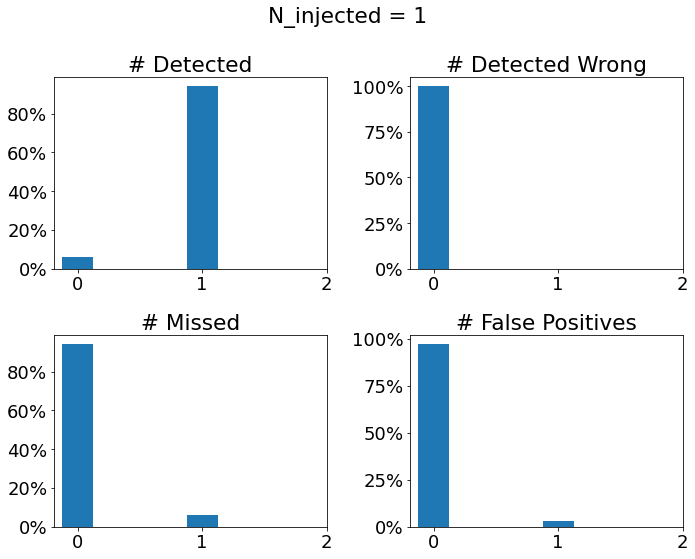

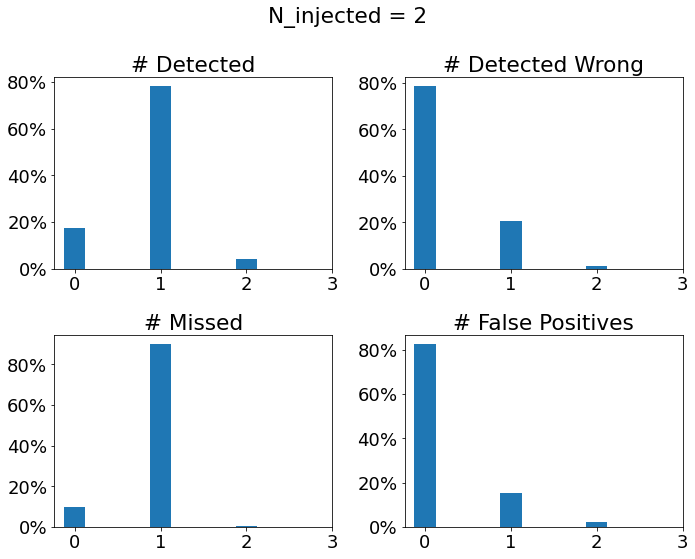

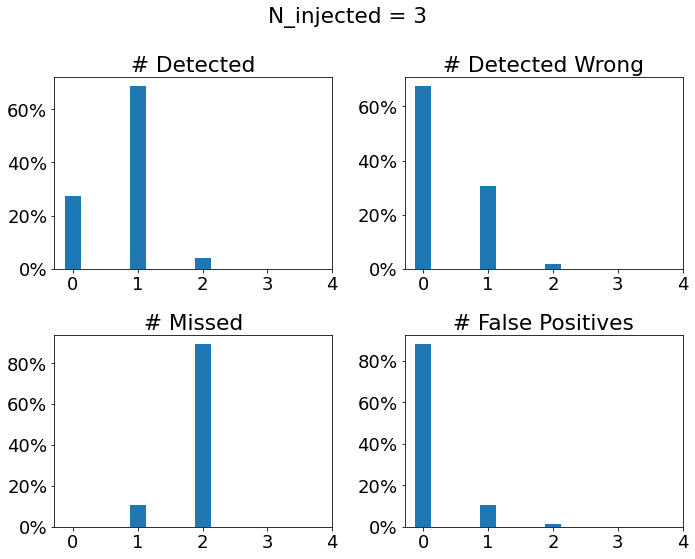

In [8]:
# Plot up a summary of the statistics for each of the light curves, sorted by number of flares injected.
for i in range(3):
    # Look for those light curves with this many injected flares (1, 2, or 3).
    n_inj_flares = i+1
    where_n_flares = np.where(all_n_in_visit == n_inj_flares)[0]
    these_n_det = all_n_det[where_n_flares]
    these_n_det_wrongenergy = all_n_det_wrongenergy[where_n_flares]
    these_n_miss = all_n_miss[where_n_flares]
    these_n_fp = all_n_fp[where_n_flares]
    fig, (ax_row1, ax_row2) = plt.subplots(2, 2, figsize=(10, 8))

    # Plot distribution of number of flares detected.
    ax_row1[0].set_title("# Detected")
    ax_row1[0].hist(these_n_det, bins=range(n_inj_flares+2), density=True, align='left', rwidth=0.25)
    ax_row1[0].set_xticks(range(n_inj_flares+2))
    ax_row1[0].yaxis.set_major_formatter(PercentFormatter(1))

    # Plot distribution of number of flares detected.
    ax_row1[1].set_title("# Detected Wrong")
    ax_row1[1].hist(these_n_det_wrongenergy, bins=range(n_inj_flares+2), density=True, align='left', rwidth=0.25)
    ax_row1[1].set_xticks(range(n_inj_flares+2))
    ax_row1[1].yaxis.set_major_formatter(PercentFormatter(1))
    
    # Plot distribution of number of flares missed.
    ax_row2[0].set_title("# Missed")
    ax_row2[0].hist(these_n_miss, bins=range(n_inj_flares+2), density=True, align='left', rwidth=0.25)
    ax_row2[0].set_xticks(range(n_inj_flares+2))
    ax_row2[0].yaxis.set_major_formatter(PercentFormatter(1))
    
    # Plot distribution of number of false positive detections.
    ax_row2[1].set_title("# False Positives")
    ax_row2[1].hist(these_n_fp, bins=range(n_inj_flares+2), density=True, align='left', rwidth=0.25)
    ax_row2[1].set_xticks(range(n_inj_flares+2))
    ax_row2[1].yaxis.set_major_formatter(PercentFormatter(1))
    
    fig.suptitle("N_injected = " + str(n_inj_flares))
    fig.tight_layout()

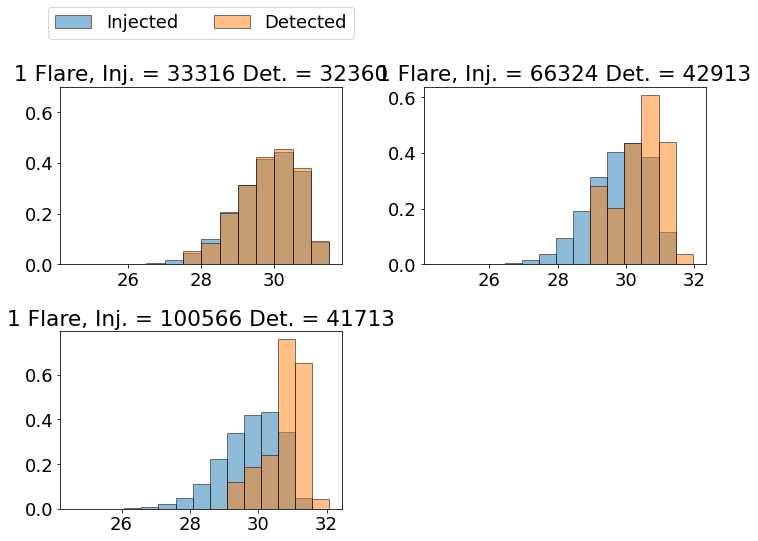

In [9]:
# Plot histograms comparing the injected and detected energies for the cases of 1, 2, and 3
# injected flares.
fig, (ax_row1, ax_row2) = plt.subplots(2, 2, figsize=(10, 8))

# Setup histogram bins, grouped by log10(E).
energy_binstep = 0.5
energy_bins_n1 = np.arange(
    min([min(all_injected_flare_energies_n1), min(all_detected_flare_energies_n1)]),
    max([max(all_injected_flare_energies_n1), max(all_detected_flare_energies_n1)]) + energy_binstep,
    energy_binstep)
energy_bins_n2 = np.arange(
    min([min(all_injected_flare_energies_n2), min(all_detected_flare_energies_n2)]),
    max([max(all_injected_flare_energies_n2), max(all_detected_flare_energies_n2)]) + energy_binstep,
    energy_binstep)
energy_bins_n3 = np.arange(
    min([min(all_injected_flare_energies_n3), min(all_detected_flare_energies_n3)]),
    max([max(all_injected_flare_energies_n3), max(all_detected_flare_energies_n3)]) + energy_binstep,
    energy_binstep)

# Cases of a single inected flare.
ax_row1[0].set_title("1 Flare, Inj. = " + str(len(all_injected_flare_energies_n1)) +
                    " Det. = " + str(len(all_detected_flare_energies_n1)))
ax_row1[0].hist(all_injected_flare_energies_n1, bins=energy_bins_n1, density=True, align='left', rwidth=1.0,
                alpha=0.5, label="Injected", edgecolor="black")
ax_row1[0].hist(all_detected_flare_energies_n1, bins=energy_bins_n1, density=True, align='left', rwidth=1.0,
               alpha=0.5, label="Detected", edgecolor="black")
ax_row1[0].set_ylim(0., 0.7)
ax_row1[0].legend(loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.0, 0.0, 0.5))


# Cases of two inected flares.
ax_row1[1].set_title("1 Flare, Inj. = " + str(len(all_injected_flare_energies_n2)) +
                    " Det. = " + str(len(all_detected_flare_energies_n2)))
ax_row1[1].hist(all_injected_flare_energies_n2, bins=energy_bins_n2, density=True, align='left', rwidth=1.0,
                alpha=0.5, edgecolor="black")
ax_row1[1].hist(all_detected_flare_energies_n2, bins=energy_bins_n2, density=True, align='left', rwidth=1.0,
               alpha=0.5, edgecolor="black")

# Cases of three inected flares.
ax_row2[0].set_title("1 Flare, Inj. = " + str(len(all_injected_flare_energies_n3)) +
                    " Det. = " + str(len(all_detected_flare_energies_n3)))
ax_row2[0].hist(all_injected_flare_energies_n3, bins=energy_bins_n3, density=True, align='left', rwidth=1.0,
                alpha=0.5, edgecolor="black")
ax_row2[0].hist(all_detected_flare_energies_n3, bins=energy_bins_n3, density=True, align='left', rwidth=1.0,
               alpha=0.5, edgecolor="black")

ax_row2[1].axis("off")
fig.tight_layout()